# Hyperparameter Adjust
## 0. Summary
To minimize what essential to look, I created this notebook for hyperparameter adjustment

Function are actually full code but minimized.
* [1. Install dependencies](#1)
* [2. Input Data](#2)
* [3. Data Generator](#3)
* [4. Setting](#4)
* [5. Model](#5)
* [6. Train](#6)
* [7. Evaluate](#7)
* [8. Prediction](#8)
* [9. Visualize](#9)

<a id='1'></a>
## 1. Install dependencies

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
from tqdm import tqdm
import random


import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical

import tensorflow as tf

from sklearn.model_selection import train_test_split

import os

Using TensorFlow backend.


<a id='2'></a>
## 2. Input Data

In [2]:
def read_to_pandas(path):
    filename = []
    category = []

    folders = [x for x in os.listdir(path)]
    folders.sort()

    i = 0
    for folder in folders:
        
        folder = os.path.join(path,folder)
        files = os.listdir(folder)

        for file in tqdm(files,desc=folder.split('/')[-1]):
            
            file = os.path.join(folder, file)
            filename += [file]
            category += [str(i)]

        i += 1
    
    df = pd.DataFrame({
        'filename': filename,
        'category': category
    })
    
    return df
        

In [3]:
def read_refer(path):
    refer = {}
    folders = [x for x in os.listdir(path)]
    folders.sort()
    i = 0
    
    for folder in folders:
        refer.update({str(i):folder})
        i +=1 
        
    return refer

In [4]:
def show_img(df):
    i = 0
    plt.figure(figsize=(12,12))
    for index, row in df.iterrows():
        filename = row['filename']
        category = row['category']

        img = load_img(filename)
        plt.subplot(5, 6, i + 1)
        plt.imshow(img)
        plt.xlabel('(' + "{}. {}".format(category,refer[category]) + ')' )

        i += 1

    plt.tight_layout()
    plt.show()


n9: 100%|██████████| 26/26 [00:00<00:00, 34142.74it/s]


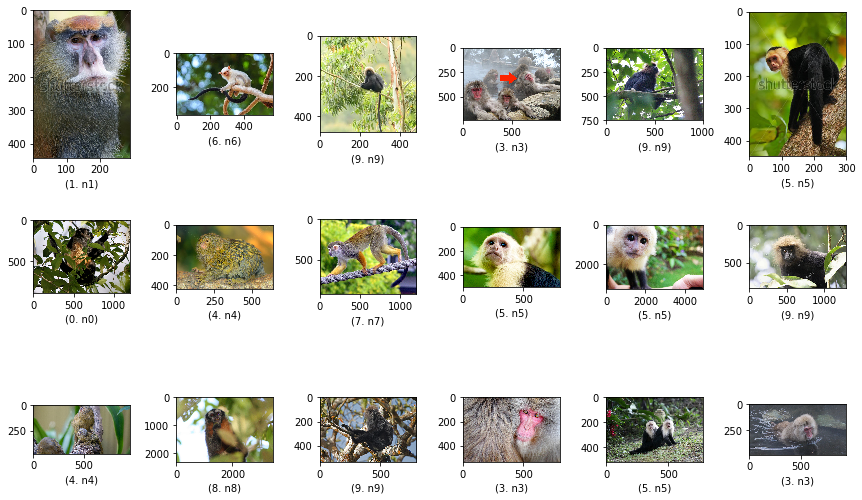

In [5]:
monkey_path = "../input/10-monkey-species/training/training"
monkey_valid_path = "../input/10-monkey-species/validation/validation"

cactus_path = "../input/cactus-aerial-photos/training_set/training_set"
cactus_valid_path = "../input/cactus-aerial-photos/training_set/training_set"

df = read_to_pandas(monkey_path)
test_df = read_to_pandas(monkey_valid_path)

refer = read_refer(monkey_path)

df.sample(n=5)['category'].tolist()
show_img(df.sample(n=18))

<a id='3'></a>
## 3. Data Generator

In [6]:
class_mode = 'categorical'

def split_data(df,test_size=0.2):
    df = df.sample(frac=1)

    train_df, validation_df = train_test_split(df, test_size=test_size, random_state=42)
    train_df = train_df.reset_index(drop=True)
    validation_df = validation_df.reset_index(drop=True)
    
    return train_df, validation_df

def train_datagen():
    train_datagen = ImageDataGenerator(
        rotation_range=10,
        shear_range=0.05,
        zoom_range=[0.85,1],
        horizontal_flip=True,
        validation_split=0.1,
        rescale=1./255
    )
    return train_datagen
    
def test_datagen():
    test_datagen = ImageDataGenerator(rescale=1./255)
    return test_datagen

def generator_from(datagen, data_df, IMAGE_SIZE, batch_size):
    generator = datagen.flow_from_dataframe(
        data_df, 
        "", 
        x_col='filename',
        y_col='category',
        target_size=IMAGE_SIZE,
        class_mode=class_mode,
        batch_size=batch_size
    )
    return generator

In [7]:
def generator_example(generator):
    plt.figure(figsize=(12, 12))
    for i in range(0, 6):
        plt.subplot(5, 3, i+1)
        plt.imshow(generator[0][0][0])
        break
    plt.tight_layout()
    plt.show()
    
    print(generator[0][1][0])

Found 877 images belonging to 10 classes.
Found 220 images belonging to 10 classes.


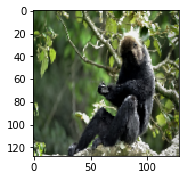

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [8]:
image_size = (128, 128)
batch_size = 64
class_mode = 'categorical'

train_df,valid_df = split_data(df)
#valid_df, test_df = split_data(valid_df)
train_gen = generator_from(train_datagen(),train_df,image_size, batch_size)
valid_gen = generator_from(test_datagen(),valid_df,image_size, batch_size)

generator_example(train_gen)

<a id='4'></a>
## 4. Setting 

In [9]:
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

log_dir =''
def tensorboard_callback():
    import datetime
    log_dir="./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)#, histogram_freq=1)
    return tensorboard_callback

def modelcheckpoint():
    modelcheckpoint = ModelCheckpoint(filepath='./model.weights.best.hdf5',
                                  monitor="val_acc", 
                                  verbose = 1, 
                                  save_best_only=True)
    return modelcheckpoint

def earlystop():
    earlystop = EarlyStopping(patience=10)

def learning_rate_reduction():
    learning_rate_reduction= ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
    return learning_rate_reduction


In [10]:
epochs=30
loss='categorical_crossentropy'
optimizer=Adam(0.001)
callbacks = [modelcheckpoint()]

Instructions for updating:
Colocations handled automatically by placer.


<a id='5'></a>
## 5. Model

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

def model_1(input_shape,n_out):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))

    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.75))

    model.add(Dense(n_out, activation='softmax'))

    return model

In [12]:
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import InceptionResNetV2

def model_2(input_shape, n_out):
        
    path = 'C:\\vs2015shareddata\\model_weight\\inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
    path = "../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights=path, 
        input_shape=input_shape)    
    
    pretrain_model.trainable = False
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='softmax')(x)
    model = Model(input_tensor, output)
    
    return model

In [13]:
def model_3(input_shape, n_out):  
    # Pre-trained model with MobileNetV2# Pre-trained model with MobileNetV2
    path = 'C:\\vs2015shareddata\\model_weight\\mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_96_no_top.h5'
    path = 'imagenet'
    
    base_model = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights=path
    )
    
    base_model.trainable = False
    
    maxpool_layer = keras.layers.GlobalMaxPooling2D()
    prediction_layer = keras.layers.Dense(n_out, activation='softmax')
    
    model = keras.models.Sequential([
        base_model,
        maxpool_layer,
        prediction_layer
    ])
    
    return model

In [14]:
def model_4(input_shape, n_out):  
    
    from keras.applications.resnet50 import ResNet50
    path = ''
    path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
    
    resnet_model = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights=path
    )
    
    resnet_model.trainable = False
    
    dense1 = keras.layers.Dense(1024, activation='relu')
    dropout = keras.layers.Dropout(rate = 0.5)
    output = keras.layers.Dense(n_out, activation='softmax')
    
    model = keras.models.Sequential([
        resnet_model,
        dense1,
        dropout,
        output
    ])
    
    return model

In [15]:
model = model_2(train_gen[0][0][0].shape,len(refer))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 128, 128, 3)       12        
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 2, 2, 1536)        54336736  
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 2, 2, 128)         196736    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
__________

<a id='6'></a>
## 6. Train

In [17]:
 def train_1(epochs=epochs,initial_epoch = 0):
    history = model.fit_generator(
        train_datagen.flow(
            train_df['filename'], train_df['category'], 
            batch_size=batch_size),
        epochs = epochs, 
        initial_epoch = initial_epoch,
        validation_data = (valid_df['filename'],valid_df['category']),
        verbose = 1, 
        steps_per_epoch=x_train.shape[0] // batch_size
    )
    return history

def train_2(epochs=epochs,initial_epoch = 0):
    history = model.fit_generator(
        train_gen, 
        epochs=epochs,
        initial_epoch = initial_epoch,
        validation_data=valid_gen,
        validation_steps=valid_df.shape[0]//batch_size,
        steps_per_epoch=train_df.shape[0]//batch_size,
        callbacks=callbacks
    )
    return history

In [18]:
history = train_2(epochs = 50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
13/13 [==============================] - 54s 4s/step - loss: 2.4134 - acc: 0.1202 - val_loss: 2.1331 - val_acc: 0.3229

Epoch 00001: val_acc improved from -inf to 0.32292, saving model to ./model.weights.best.hdf5
Epoch 2/50
13/13 [==============================] - 9s 689ms/step - loss: 2.1859 - acc: 0.2058 - val_loss: 1.9912 - val_acc: 0.4808

Epoch 00002: val_acc improved from 0.32292 to 0.48077, saving model to ./model.weights.best.hdf5
Epoch 3/50
13/13 [==============================] - 25s 2s/step - loss: 2.0005 - acc: 0.2894 - val_loss: 3.5220 - val_acc: 0.5192

Epoch 00003: val_acc improved from 0.48077 to 0.51923, saving model to ./model.weights.best.hdf5
Epoch 4/50
13/13 [==============================] - 22s 2s/step - loss: 1.8050 - acc: 0.3945 - val_loss: 3.3856 - val_acc: 0.5705

Epoch 00004: val_acc improved from 0.51923 to 0.57051, saving model to ./model.weights.best.hdf5
Epoch 5/50
13/13 [=======================

Fine-tune

In [19]:
model.layers[2].trainable = True
model.compile(loss=loss, optimizer=Adam(lr = 0.0001), metrics=['accuracy'])
ft_history = train_2(epochs = 100,initial_epoch = 50)

Epoch 51/100
13/13 [==============================] - 90s 7s/step - loss: 0.3265 - acc: 0.9057 - val_loss: 0.6889 - val_acc: 0.7756

Epoch 00051: val_acc did not improve from 0.78846
Epoch 52/100
13/13 [==============================] - 21s 2s/step - loss: 0.2561 - acc: 0.9148 - val_loss: 0.6109 - val_acc: 0.8141

Epoch 00052: val_acc improved from 0.78846 to 0.81410, saving model to ./model.weights.best.hdf5
Epoch 53/100
13/13 [==============================] - 17s 1s/step - loss: 0.2186 - acc: 0.9324 - val_loss: 0.6042 - val_acc: 0.8974

Epoch 00053: val_acc improved from 0.81410 to 0.89744, saving model to ./model.weights.best.hdf5
Epoch 54/100
13/13 [==============================] - 27s 2s/step - loss: 0.1555 - acc: 0.9497 - val_loss: 0.6058 - val_acc: 0.8906

Epoch 00054: val_acc did not improve from 0.89744
Epoch 55/100
13/13 [==============================] - 26s 2s/step - loss: 0.1693 - acc: 0.9526 - val_loss: 0.6338 - val_acc: 0.8846

Epoch 00055: val_acc did not improve from

<a id='7'></a>
## 7. Evaluate

In [20]:
def show_result(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], color='b', label="Training loss")
    plt.plot(history.history['val_loss'], color='r', label="validation loss")
    legend = plt.legend(loc='best', shadow=True)

    plt.subplot(1,2,2)
    plt.plot(history.history['acc'], color='b', label="Training accuracy")
    plt.plot(history.history['val_acc'], color='r',label="Validation accuracy")
    legend = plt.legend(loc='best', shadow=True)

    plt.tight_layout()
    plt.show()

    #plt.xticks(np.arange(1, epochs, 1))
    #plt.yticks(np.arange(0, 1, 0.1))


Found 272 images belonging to 10 classes.
loss: 0.3483 acc: 0.8971


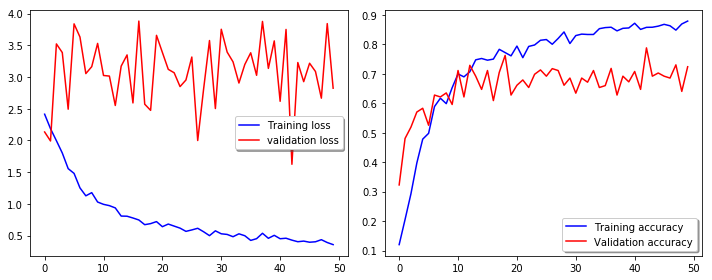

In [21]:
model.save_weights("./model.h5")
model.load_weights('./model.weights.best.hdf5')

test_gen = generator_from(test_datagen(),test_df,image_size, batch_size)
score = model.evaluate_generator(test_gen,steps = 100)

print('loss: {:.4f}'.format(score[0]),'acc: {:.4f}'.format(score[1]))
show_result(history)

<a id='8'></a>
## 8. Prediction

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def predict_df(test_df, test_gen):
    predict = []
    predict = model.predict_generator(test_gen, steps=np.ceil(test_df.shape[0]/batch_size))
    
    #print(test_gen[0][0].shape)
    #print(test_df.shape[0])
    #predict = [[int(i <= 0.5),int(i > 0.5)] for i in predict]

    test_df[[str(i) for i in range(len(refer))]] = pd.DataFrame(predict, index=test_df.index )

    test_df['true'] = test_gen.classes
    test_df['result'] = [np.argmax(i) for i in predict]
    test_df['prob'] = [i[np.argmax(i)] for i in predict]
    
    return test_df

def show_predict(test_df):
    sample_test = test_df.sample(n = 18)
    sample_test = sample_test.reset_index(drop=True)

    plt.figure(figsize=(12,12))
    for index, row in sample_test.iterrows():
        filename = row['filename']
        result = row['result']
        probability = row['prob']
        img = load_img(filename)
        plt.subplot(6, 3, index + 1)
        plt.imshow(img)
        plt.xlabel(filename.split('/')[-2] + '(' + "{}".format(refer[str(result)]) + ' - ' + "{:.2f}".format(probability) + ')')
    plt.tight_layout()
    plt.show()
    
def save_predict(test_df):
    submission_df = test_df.copy()
    submission_df['id'] = submission_df['filename'].str.split('/').str[-1].str.split('.').str[0]
    submission_df['prob'] = submission_df['prob'].astype(np.float16)
    submission_df.drop(['filename'], axis=1, inplace=True)
    submission_df.to_csv('submission.csv', index=False)

In [23]:
def get_matrix(df):
    true_label = list(df['category'])
    pred_label = list(df['result'])
    output = np.array([[0 ] * len(refer)]* len(refer))
    for i in range(len(true_label)):
        a = int(true_label[i])
        b = int(pred_label[i])
        output[a][b] += 1
    return output        

def show_matrix(cm,normalize=False):
    classes = refer.values()
    title=None
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

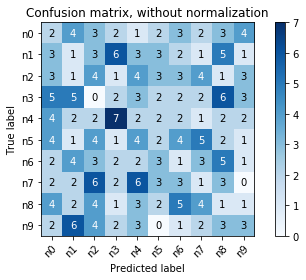

In [24]:
result_df = predict_df(test_df,test_gen)

show_matrix(get_matrix(result_df))
#show_predict(result_df)

In [25]:
save_predict(result_df)
output_df = pd.read_csv('submission.csv')
output_df.sample(n=5)

,category,0,1,2,3,4,5,6,7,8,9,true,result,prob,id
241,8,2.583852e-12,2.910628e-11,5.809698e-12,3.457802e-11,9.999999e-01,5.205844e-12,1.629375e-09,1.667212e-10,1.297305e-07,1.223525e-12,8,4,1.0000,n8013
237,8,4.934710e-03,2.584271e-03,5.203949e-04,1.763227e-04,1.069459e-01,1.820180e-04,3.200453e-05,8.300343e-04,6.228731e-04,8.831714e-01,8,9,0.8833,n812
204,7,4.728045e-09,3.564573e-10,2.703339e-15,5.039574e-14,1.952419e-12,1.127208e-11,1.018208e-14,4.227255e-08,1.000000e+00,8.807267e-11,7,8,1.0000,n7017
93,3,9.859590e-01,7.951511e-13,3.292315e-13,6.455141e-14,1.107282e-11,2.168668e-08,1.583090e-14,2.811861e-11,2.402397e-12,1.404101e-02,3,0,0.9860,n319
140,5,4.177538e-22,1.565311e-17,1.000000e+00,1.354701e-16,2.737485e-19,6.944941e-18,5.774864e-20,2.675391e-17,7.511150e-21,2.296579e-23,5,2,1.0000,n514


<a id = '9'></a>
## 9. Visualize

In [26]:
def get_CAM(filename, predicted_label):
    """
    This function is used to generate a heatmap for a sample image prediction.
    
    Args:
        processed_image: any sample image that has been pre-processed using the 
                       `preprocess_input()`method of a keras model
        predicted_label: label that has been predicted by the network for this image
    
    Returns:
        heatmap: heatmap generated over the last convolution layer output 
    """
    processed_image = load_img(filename)
    
    # we want the activations for the predicted label
    predicted_output = model.output[:, predicted_label]
    
    # choose the last conv layer in your model
    last_conv_layer = model.get_layer('block5_conv3')
    
    # get the gradients wrt to the last conv layer
    grads = K.gradients(predicted_output, last_conv_layer.output)[0]
    
    # take mean gradient per feature map
    grads = K.mean(grads, axis=(0,1,2))
    
    # Define a function that generates the values for the output and gradients
    evaluation_function = K.function([model.input], [grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = evaluation_function([processed_image])
    
    # iterate over each feature map in yout conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    for i in range(512): # we have 512 features in our last conv layer
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    return heatmap

In [27]:
def show_random_sample(idx):
    """
    This function is used to select a random sample from the validation dataframe.
    It generates prediction for the same. It also stores the heatmap and the intermediate
    layers activation maps.
    
    Arguments:
        idx: random index to select a sample from validation data
    
    Returns:
        activations: activation values for intermediate layers
    """
    # select the sample and read the corresponding image and label
    sample_image = cv2.imread(valid_df.iloc[idx]['image'])
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    sample_image = cv2.resize(sample_image, (img_rows, img_cols))
    sample_label = valid_df.iloc[idx]["label"]
    
    # pre-process the image
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    sample_image_processed = preprocess_input(sample_image_processed)
    
    # generate activation maps from the intermediate layers using the visualization model
    activations = vis_model.predict(sample_image_processed)
    
    # get the label predicted by our original model
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    # choose any random activation map from the activation maps 
    sample_activation = activations[0][0,:,:,32]
    
    # normalize the sample activation map
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    # convert pixel values between 0-255
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    
    
    # get the heatmap for class activation map(CAM)
    heatmap = get_CAM(sample_image_processed, pred_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    super_imposed_image = heatmap * 0.5 + sample_image
    super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)

    f,ax = plt.subplots(2,2, figsize=(15,8))
    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.show()
    
    return activations

In [28]:
get_CAM(valid_df['filename'][0],valid_df['category'][0])

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got '2'

In [29]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(8, 8)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()